In [1]:
library(tidyverse)
library(stringr)
library(DBI)
library(RSQLite)
library(lubridate)
library(dplyr)

library(repr)
options(repr.plot.width=4, repr.plot.height=4)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
sales <- read_delim("roger_final_sales_data.csv", "|")
adwords <- read_delim("roger_final_adwords.csv", "|")

glimpse(adwords)

Parsed with column specification:
cols(
  purchase_date = col_datetime(format = ""),
  order_status = col_character(),
  product_name = col_character(),
  quantity = col_integer(),
  currency = col_character(),
  price = col_double(),
  promotion_id = col_character(),
  discount = col_double(),
  city = col_character(),
  state = col_character(),
  postcode = col_character(),
  country = col_character(),
  product_code = col_integer(),
  size = col_character()
)
Parsed with column specification:
cols(
  Cost = col_double(),
  Clicks = col_integer(),
  Avg = col_double(),
  YMD = col_date(format = "")
)


Observations: 136
Variables: 4
$ Cost   <dbl> 195.79, 197.27, 193.24, 180.57, 222.57, 175.78, 153.65, 222....
$ Clicks <int> 284, 289, 278, 261, 319, 312, 311, 416, 359, 436, 207, 319, ...
$ Avg    <dbl> 0.69, 0.68, 0.70, 0.69, 0.70, 0.56, 0.49, 0.54, 0.58, 0.49, ...
$ YMD    <date> 2017-07-01, 2017-07-02, 2017-07-03, 2017-07-04, 2017-07-05,...


In [3]:
# I want to summarize daily data by week.  How do I do that?
# Add "week" column to adwords
adwords$week <- lubridate::isoweek(adwords$YMD)

# Need to eliminate first and last weeks (26 and 46) because they look like partials
sliced_adwords <- filter(adwords, week > 26, week < 46)
glimpse(sliced_adwords)

Observations: 133
Variables: 5
$ Cost   <dbl> 193.24, 180.57, 222.57, 175.78, 153.65, 222.62, 208.38, 214....
$ Clicks <int> 278, 261, 319, 312, 311, 416, 359, 436, 207, 319, 116, 262, ...
$ Avg    <dbl> 0.70, 0.69, 0.70, 0.56, 0.49, 0.54, 0.58, 0.49, 0.59, 0.57, ...
$ YMD    <date> 2017-07-03, 2017-07-04, 2017-07-05, 2017-07-06, 2017-07-07,...
$ week   <int> 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, ...


In [4]:
# Adwords clicks and cost grouped-by Week 
adwords_by_week <- sliced_adwords %>% group_by(week)
adwords_sum_by_week <- adwords_by_week %>% summarize(
    clicks = sum(Clicks),
    cost = sum(Cost)
    )
glimpse(adwords_sum_by_week)

Observations: 19
Variables: 3
$ week   <int> 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, ...
$ clicks <int> 2256, 2038, 2257, 2266, 2235, 2695, 2096, 2039, 2011, 2311, ...
$ cost   <dbl> 1356.81, 1125.26, 1486.39, 1583.90, 1451.17, 1526.86, 1262.3...


In [5]:
# Need to aggregate sales by week too

# Cast purchase_date as YMD
sales$ymd_date <- sales$purchase_date %>% str_sub( 1, 10) %>% ymd()

# Create a week column
sales$week <- lubridate::isoweek(sales$ymd_date)

# Trim off the partial weeks from start and end
sales <- filter(sales, week != "26", week != "46")

# Group Sales by Week
sales_by_week <- sales %>% group_by(week)
sales_sum_by_week <- sales_by_week %>% summarize(
    price = sum(price)
    )

# I want a "date" field back so that I can use it as an axis label in my plot
sales_sum_by_week$date <- as.Date(paste(2017, sales_sum_by_week$week, 1, sep="-"), "%Y-%U-%u")

# Sales grouped-by Day
sales_by_day <- sales %>% group_by(ymd_date)
sales_sum_by_day <- sales_by_day %>% summarize(
    price = sum(price)
    )

# Sales grouped by product_name
sales_by_product <- sales %>% group_by(product_name)
sales_sum_by_product <- sales_by_product %>% summarize(
    price = sum(price)
    )


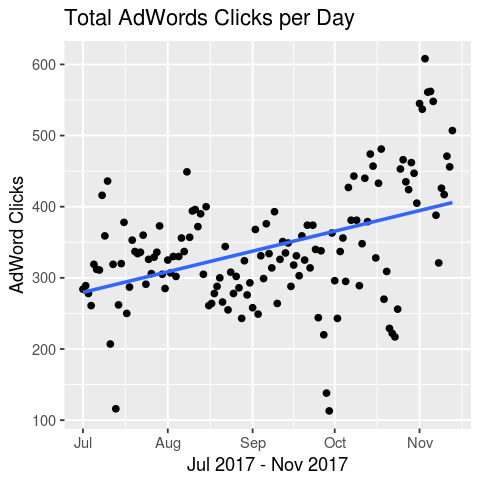

In [6]:
# Plot an easy one, AdWords clicks per day
ggplot(data = adwords, mapping = aes(x = YMD, y = Clicks)) +
   geom_point() +
   geom_smooth(method = "lm", se = FALSE) +
   xlab("Jul 2017 - Nov 2017") +
   ylab("AdWord Clicks") +
   ggtitle("Total AdWords Clicks per Day")

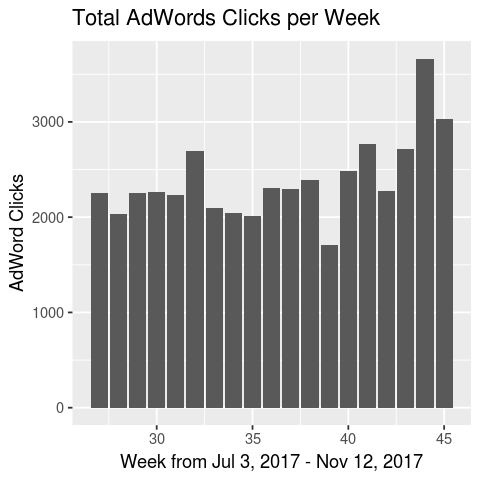

In [7]:
# Plot clicks per week as a barchart
ggplot(data = adwords_sum_by_week, mapping = aes(x = week, y = clicks)) +
   geom_col() +
   xlab("Week from Jul 3, 2017 - Nov 12, 2017") +
   ylab("AdWord Clicks") +
   ggtitle("Total AdWords Clicks per Week")

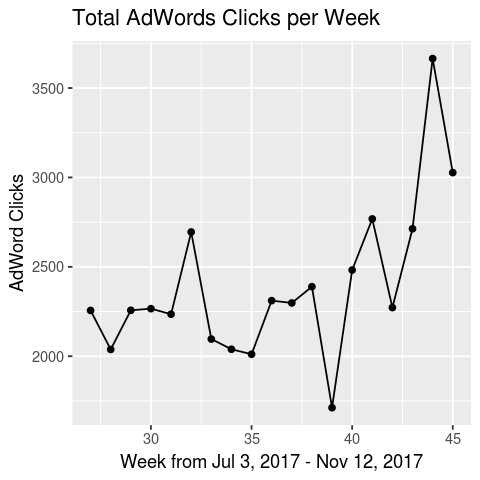

In [8]:
# Plot clicks per week as a dot plot
ggplot(data = adwords_sum_by_week, mapping = aes(x = week, y = clicks)) +
  geom_line() +
   geom_point() +
   xlab("Week from Jul 3, 2017 - Nov 12, 2017") +
   ylab("AdWord Clicks") +
   ggtitle("Total AdWords Clicks per Week")

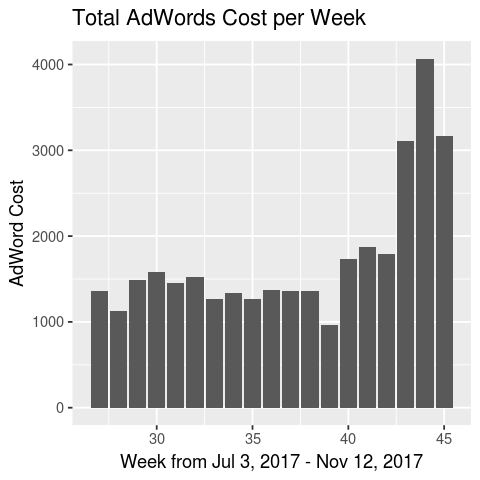

In [9]:
# Plot AdWords cost per week as a bar plot
ggplot(data = adwords_sum_by_week, mapping = aes(x = week, y = cost)) +
   geom_col() +
   xlab("Week from Jul 3, 2017 - Nov 12, 2017") +
   ylab("AdWord Cost") +
   ggtitle("Total AdWords Cost per Week")

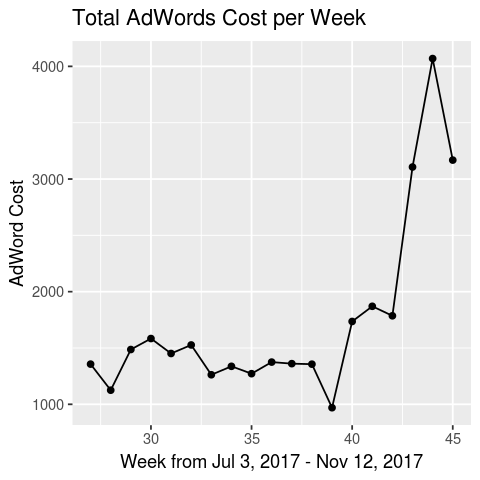

In [10]:
# Plot AdWords cost per week as a dot plot
ggplot(data = adwords_sum_by_week, mapping = aes(x = week, y = cost)) +
  geom_line() +
   geom_point() +
   xlab("Week from Jul 3, 2017 - Nov 12, 2017") +
   ylab("AdWord Cost") +
   ggtitle("Total AdWords Cost per Week")

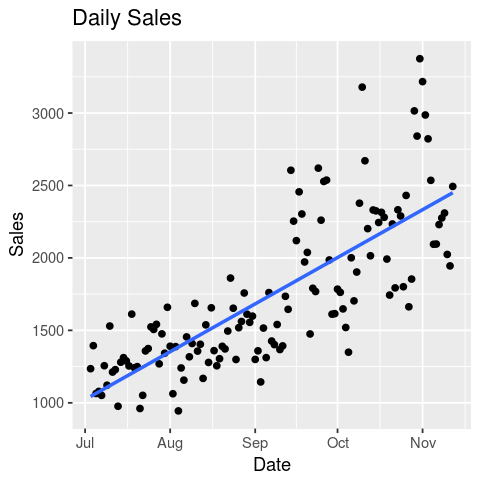

In [11]:
# Plot Sales revenue per day as a dot plot
ggplot(data = sales_sum_by_day, mapping = aes(x = ymd_date, y = price)) +
   geom_point() +
   geom_smooth(method = "lm", se = FALSE) +
   xlab("Date") +
   ylab("Sales") +
   ggtitle("Daily Sales")

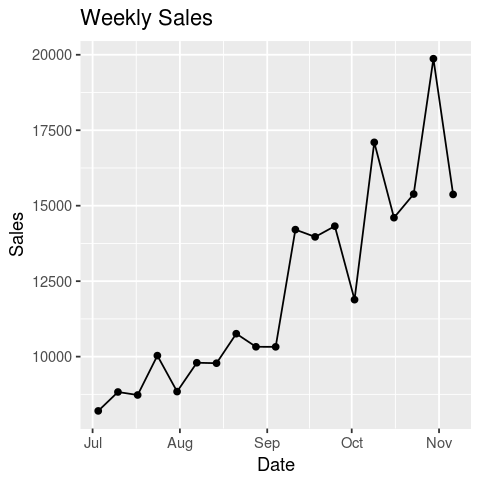

In [12]:
# Plot Sales revenue per week as a dot plot
ggplot(data = sales_sum_by_week, mapping = aes(x = date, y = price)) +
   geom_point() +
   geom_line() +
   xlab("Date") +
   ylab("Sales") +
   ggtitle("Weekly Sales")

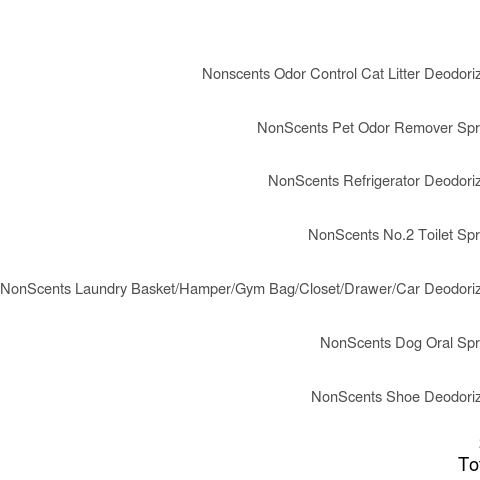

In [13]:
# Plot Total Sales by Product
myplot <- sales_sum_by_product %>% ggplot(mapping = aes(x = reorder(product_name, price), y = price)) +
   geom_col() +
   xlab("Product Name") +
   ylab("Total Sales") +
   coord_flip() +
   ggtitle("Total Sales by Product")
plot(myplot)